In [1]:
### Notebook to carry out Bayesian optimisaton and inspect the results
### Here is an outline of BO on the ITC parameters, optimising THRESHcrown, SOBELstr and tau

In [1]:
### General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

### --- Figure config
LEGEND_SIZE = 15

### Emukit and GPy imports

from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

# this is the only input
cost = pd.read_csv('/home/jovyan/lustre_scratch/bo/split_search_and_crown/costs/low_tau/Cost_params_603450.csv')

# THRESHSeed and THRESHCrown are closely related, may only need one of them

x = cost[['THRESHCrown', 'SOBELstr','tau']]
X = x.to_numpy()

# for a plot 

#THRESHSeed = cost['THRESHSeed']
#THRESHCrown = cost['THRESHCrown']
#SOBELstr = cost['SOBELstr']
#tau = cost['tau']

mean_cost = cost['min_f']

# Need to figure out what is going on with this one

parameter_space = ParameterSpace([ContinuousParameter('THRESHCrown', 0.6, 0.95), ContinuousParameter('SOBELstr', 20, 60), ContinuousParameter('tau',39,99)])

mean_cost = cost['min_f']
mean_cost_array = mean_cost.to_numpy()
mean_cost_array = mean_cost_array[:, None]

import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

#gpy_model = GPy.models.GPRegression(X, mean_cost_array, GPy.kern.RBF(input_dim=3, lengthscale=0.08, variance=20), noise_var=1e-10)
gpy_model = GPy.models.GPRegression(X, mean_cost_array, GPy.kern.RBF(input_dim=3, lengthscale=3, variance=3), noise_var=0.1)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(X)

from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

ei_acquisition = ExpectedImprovement(emukit_model)
#nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
#pi_acquisition = ProbabilityOfImprovement(emukit_model)

ei_plot = ei_acquisition.evaluate(X)
#nlcb_plot = nlcb_acquisition.evaluate(X)
#pi_plot = pi_acquisition.evaluate(X)

from emukit.core.optimization import GradientAcquisitionOptimizer

optimizer = GradientAcquisitionOptimizer(parameter_space)
x_new, _ = optimizer.optimize(ei_acquisition)

# Where shall we look next!!! Sweet as. How satisfying.

print(x_new)

np.savetxt('new_bo_params.csv', x_new, delimiter=',', fmt='%f')

[[ 0.6        52.5371806  66.51892722]]


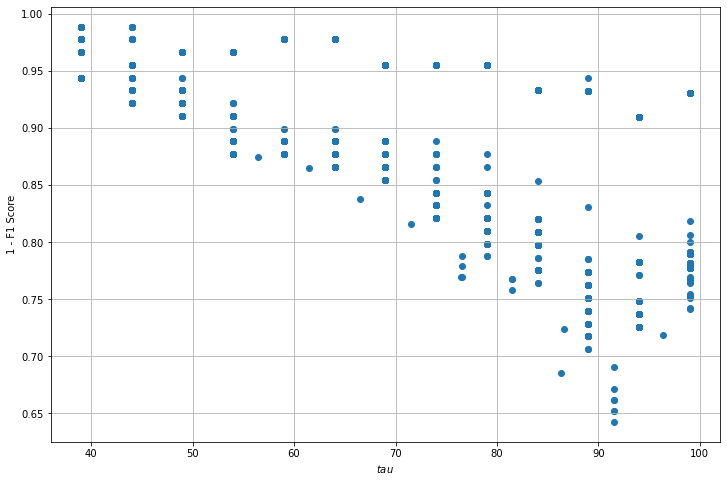

In [27]:
#THRESHSeed = cost['THRESHSeed']
THRESHCrown = cost['THRESHCrown']
SOBELstr = cost['SOBELstr']
tau = cost['tau']

min_f = cost['min_f']

plt.figure(figsize=(12, 8))
plt.scatter(tau, mean_cost)
#plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$tau$")
plt.ylabel(r"1 - F1 Score")
plt.grid(True)
#plt.xlim(0, 1)
plt.show()

In [6]:
# Need to figure out what is going on with this one
#threshseed higher than threshcrown we think - but test

parameter_space = ParameterSpace([ContinuousParameter('THRESHSeed', 0.1, 1), ContinuousParameter('THRESHCrown', 0.1, 1), ContinuousParameter('SOBELstr', 1, 65), ContinuousParameter('tau',80,99)])

In [67]:
mean_cost_array = mean_cost.to_numpy()
mean_cost_array = mean_cost_array[:, None]

In [7]:
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

#gpy_model = GPy.models.GPRegression(X, mean_cost_array, GPy.kern.RBF(input_dim=3, lengthscale=0.08, variance=20), noise_var=1e-10)
gpy_model = GPy.models.GPRegression(X, mean_cost_array, GPy.kern.RBF(input_dim=3, lengthscale=0.08, variance=20), noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(X)


In [8]:
mu_plot.shape

(957, 1)

In [9]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

ei_acquisition = ExpectedImprovement(emukit_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
pi_acquisition = ProbabilityOfImprovement(emukit_model)

ei_plot = ei_acquisition.evaluate(X)
nlcb_plot = nlcb_acquisition.evaluate(X)
pi_plot = pi_acquisition.evaluate(X)

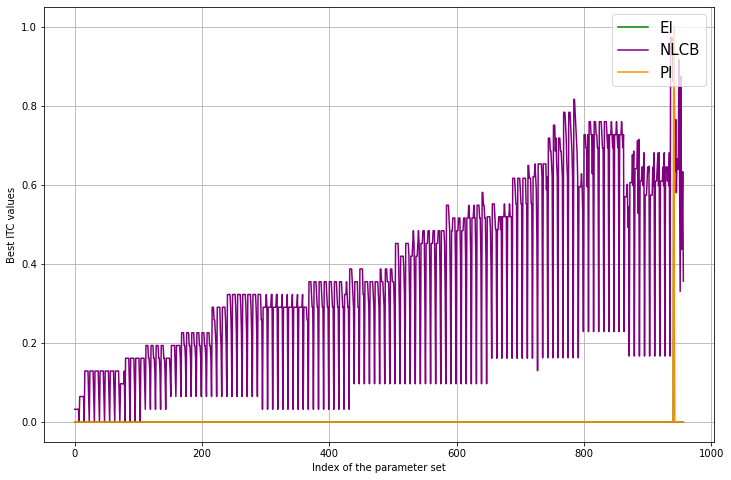

In [10]:
plt.figure(figsize=(12, 8))
plt.plot((ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.plot((nlcb_plot - np.min(nlcb_plot)) / (np.max(nlcb_plot) - np.min(nlcb_plot)), "purple", label="NLCB")
plt.plot((pi_plot - np.min(pi_plot)) / (np.max(pi_plot) - np.min(pi_plot)), "darkorange", label="PI")

plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel('Index of the parameter set')
plt.ylabel("Best ITC values")
plt.grid(True)
#plt.xlim(0, 1)
plt.show()


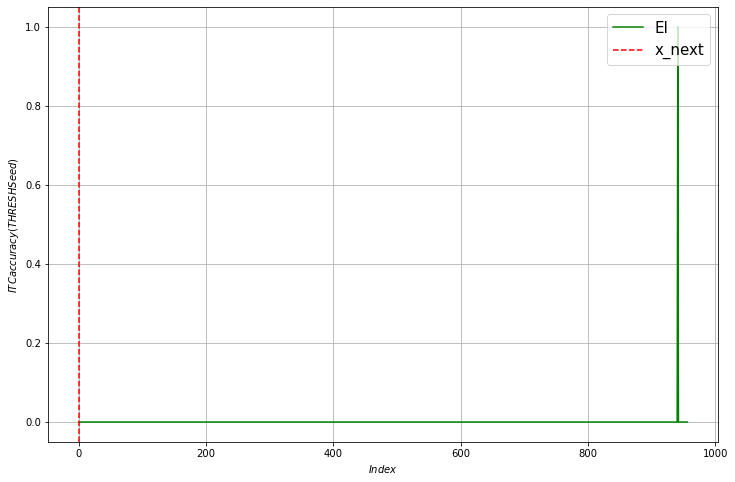

In [14]:
from emukit.core.optimization import GradientAcquisitionOptimizer

optimizer = GradientAcquisitionOptimizer(parameter_space)
x_new, _ = optimizer.optimize(ei_acquisition)

plt.figure(figsize=(12, 8))
plt.plot((ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.axvline(x_new.all(), color="red", label="x_next", linestyle="--")
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$Index$")
plt.ylabel(r"$ITC accuracy(THRESHSeed)$")
plt.grid(True)
#plt.xlim(0, 1)
plt.show()

In [15]:
# Where shall we look next!!! Sweet as. How satisfying.

x_new

array([[ 0.12356273,  0.82243954, 29.39250534, 88.36361797]])